# TP de filtrage bayésien

Calcul de l'intégrale $\displaystyle \int_{0}^{1} cos(\frac{\pi x}{2}) \, \mathrm{d}x$ par simulation de Monte Carlo

In [30]:
import numpy as np
import numpy.random
import math
import matplotlib.pyplot as plt
from scipy.integrate import quad
import warnings

### Par MC brute

In [133]:
iterations_mc = 1000
taille_echantillon=50

def g(x):
    return(math.cos(math.pi*x/2))

def mu_n(taille_echantillon):
    """generation d'une réalisation de mu_n"""
    return({"valeur" : np.mean([g(np.random.uniform(0,1)) for i in range(taille_echantillon)]),"acceptation" : False})

def simulation_mu_n(iterations_mc,taille_echantillon,estimateur):
    """return un array de taille iterations_mc réalisations de mu_n"""
    estimation=[]
    proba_acceptation = []
    for i in range(iterations_mc):
        estimateur_value = estimateur(taille_echantillon)
        estimation.append(estimateur_value["valeur"])
        proba_acceptation.append(estimateur_value["acceptation"])
    return({"estimation" : np.array(estimation),"acceptation" : np.mean(np.array(proba_acceptation))})


In [146]:
variance_emp_1 =  np.var(simulation_mu_n(iterations_mc,taille_echantillon,mu_n)["estimation"])
variance_theo_1 = ((1/2-4/(math.pi)**2)/50)
print("variance empirique : "+str(variance_emp_1))
print("variance théorique : " + str(variance_theo_1))

variance empirique : 0.002137311479519394
variance théorique : 0.001894305308612978


### Par importance sampling

In [43]:
def developement_limite_g(x):
    """DL de g en 0"""
    return(1 - ((math.pi*x)**2)/8 )

def q_tilde(x):
    """q_tilde"""
    facteur_normalisation, err = quad(developement_limite_g,0,1)
    return(developement_limite_g(x)/facteur_normalisation)


Affichage de g et de son DL en 0

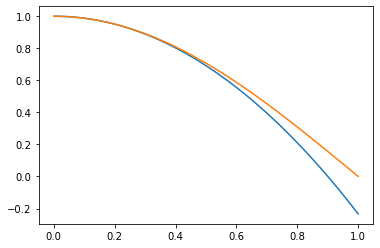

In [5]:
X = np.linspace(0,1,100)
DL= developement_limite_g(X)
G = [g(x) for x in X]
plt.plot(X,DL)
plt.plot(X,G)
plt.show()

Affichage de $\overset{\sim}{q}$ donne :


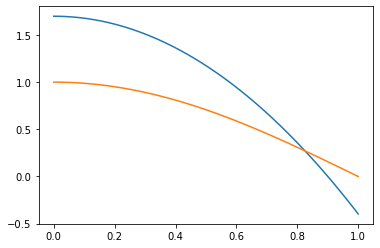

In [6]:
X = np.linspace(0,1,100)
Q= q_tilde(X)
G = [g(x) for x in X]
plt.plot(X,Q)
plt.plot(X,G)
plt.show()

In [63]:
def quotient_g_q(x,q_tilde):
    """quotient de g et q_tilde"""
    return(g(x)/q_tilde(x))

def generateur_d_estimateur(q_tilde):
    """renvoie l'estimateur mu_tilde_n"""
    return(lambda x: mu_tilde_n(x,q_tilde))

def mu_tilde_n(taille_echantillon,q_tilde):
    """generation d'une réalisation de mu_tilde_n"""
    méthode_rejet =  np.array([generation_q_tilde(q_tilde) for i in range(taille_echantillon)])
    quotient = [quotient_g_q(méthode_rejet[i,0],q_tilde) for i in range(taille_echantillon)]
    proba_acceptation = np.shape(méthode_rejet)[0]/np.sum(méthode_rejet[:,1])
    return({"valeur" : np.mean(quotient),"acceptation" : proba_acceptation})

def generation_q_tilde(q_tilde): 
    """genere une va distribuée selon la densité q_tilde, selon la méthode du rejet"""
    X = np.random.uniform(0,1,1)
    U = np.random.uniform(0,1,1)
    C= q_tilde(0)
    nombre_de_tentatives = 1
    while q_tilde(X)<C*U : 
        X = np.random.uniform(0,1,1)
        U = np.random.uniform(0,1,1)
        nombre_de_tentatives +=1
    return(X,nombre_de_tentatives)


Calcul de la variance empirique de $\hat{\mu}_{N}$ estimé par importance sampling avec le changement de probabilité
$\overset{\sim}{q}(x) = \frac{(1-\frac{\pi^{2}x^{2}}{8})}{   \displaystyle \int_{0}^{1} (1-\frac{\pi^{2}t^{2}}{8}) \, \mathrm{d}t }$

In [155]:
warnings.filterwarnings("ignore")

def integrande_var_theo(q_tilde):
        return(lambda x :g(x)*g(x)/q_tilde(x))
        
def importance_sampling(q_tilde) :
    simulation = simulation_mu_n(iterations_mc,taille_echantillon,generateur_d_estimateur(q_tilde))
    estimateur = simulation["estimation"]
    proba_acceptation = simulation["acceptation"]
    variance_emp_2 = np.var(estimateur)
    print("variance empirique importance sampling : " + str(variance_emp_2))
    print("estimation de la probabilité d'acceptation : "+ str(np.mean(proba_acceptation)))

    # variance theorique
    

    integrale,err = quad(integrande_var_theo(q_tilde),0,1)

    # calcul de la variance théorique
    variance_theo_2 = (integrale-4/((math.pi)**2))/taille_echantillon
    print("--------------")
    print("variance théorique : "+ str(variance_theo_2))

    #calcul de la probabilité d'acceptation
    print("Probabilité d'acceptation théorique : "+str(1/q_tilde(0)))

    #comparaison des deux méthodes
    print("--------------")
    print("rapport des variances  empiriques des 2 méthodes : " +str(variance_emp_2/variance_emp_1) )
    print("rapport des variances  theoriques des 2 méthodes : " +str(variance_theo_2/variance_theo_1) )


In [156]:
importance_sampling(q_tilde)

variance empirique importance sampling : 0.00038359085456333395
estimation de la probabilité d'acceptation : 0.6038371348564778
--------------
variance théorique : 0.0005195006910063227
Probabilité d'acceptation théorique : 0.5887664832879433
--------------
rapport des variances  empiriques des 2 méthodes : 0.17947353871396882
rapport des variances  theoriques des 2 méthodes : 0.27424338022190536


Autre changement de probabilité : prenons $\overset{\sim}{q}_{2}(x) = 2(1-x)$

In [98]:
def q_tilde_2(x):
    return(2*(1-x))

In [96]:
importance_sampling(q_tilde_2)

variance empirique importance sampling : 0.00012627480832509257
estimation de la probabilité d'acceptation : 0.5024566602591027
--------------
variance théorique : 0.00013569350213551656
Probabilité d'acceptation théorique : 0.5
--------------
rapport des variances  empiriques des 2 méthodes : 0.06470821890869109
rapport des variances  theoriques des 2 méthodes : 0.07163232955033641


Autre changement de probabilité : prenons $\overset{\sim}{q}_{1}(x) = g(x)$

In [97]:
importance_sampling(g)

variance empirique importance sampling : 0.0
estimation de la probabilité d'acceptation : 0.6444262067992151
--------------
variance théorique : 0.004626700755964605
Probabilité d'acceptation théorique : 1.0
--------------
rapport des variances  empiriques des 2 méthodes : 0.0
rapport des variances  theoriques des 2 méthodes : 2.442426115224427


# Verification du TCL

 Dans cette section, on estime $\mu_{N}$ un nombre $M=1000$ de fois, puis on trace l'histogramme de $\sqrt{N}(\frac{\mu_{N} - \mu}{\sigma})$ 

### Pour l'estimation "naive" de $\mu_{N}$

(array([  4.,  18.,  52., 138., 207., 234., 201.,  98.,  42.,   6.]),
 array([-3.40053554, -2.76402642, -2.12751731, -1.49100819, -0.85449907,
        -0.21798996,  0.41851916,  1.05502828,  1.69153739,  2.32804651,
         2.96455563]),
 <BarContainer object of 10 artists>)

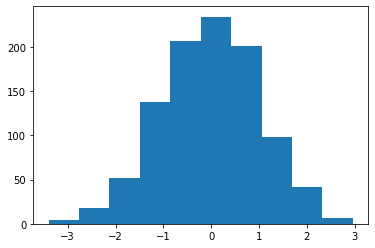

In [153]:
mu = 2/math.pi
sigma = np.sqrt((1/2-4/(math.pi)**2))
simulation = simulation_mu_n(iterations_mc,taille_echantillon,mu_n)["estimation"]
normalisation = np.sqrt(taille_echantillon)*(simulation-mu)/sigma
plt.hist(normalisation)


## Avec echantillonage préférentiel 

(array([803., 158.,  27.,   7.,   1.,   2.,   0.,   0.,   0.,   2.]),
 array([-1.95052915, -0.44344517,  1.06363881,  2.57072279,  4.07780677,
         5.58489075,  7.09197473,  8.59905871, 10.10614268, 11.61322666,
        13.12031064]),
 <BarContainer object of 10 artists>)

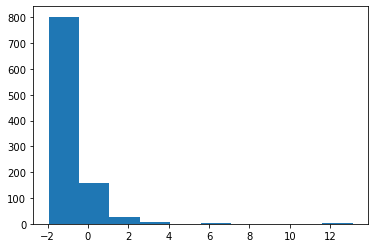

In [157]:
mu = 2/math.pi
integrale,err = quad(integrande_var_theo(q_tilde),0,1)
sigma = np.sqrt(integrale-4/((math.pi)**2))
simulation = simulation_mu_n(iterations_mc,taille_echantillon,generateur_d_estimateur(q_tilde))["estimation"]
normalisation = np.sqrt(taille_echantillon)*(simulation-mu)/sigma
plt.hist(normalisation)